In [1]:
import scipy.io
from pylab import *
from matplotlib import *
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def convert_to_df(file):
    # use scipy to load matlab file
    matlab_data = scipy.io.loadmat('data/' + str(file))
    
    # create dataframe and transpose
    df = pd.DataFrame(matlab_data['all_data']).T
    
    # create column headers
    df.columns = [
        'Mean Area Under Heart Beat',
        'Mean R-to-R Peak Interval',
        'Heart Rate',
        'Peak to Peak Blood Pressure',
        'Systolic Blood Pressure',
        'Diastolic Blood Pressure',
        'Pulse Pressure'
    ]
    
    # add labels column
    df['Golden Alarms'] = matlab_data['all_labels'][0]
    
    return df

filenames = ['1_a41178.mat', '2_a42126.mat', '3_a40076.mat', \
             '4_a40050.mat', '5_a41287.mat', '6_a41846.mat', \
             '7_a41846.mat', '8_a42008.mat', '9_a41846.mat']

patient_data = [convert_to_df(file) for file in filenames]

# floor all data
for df in patient_data:
    for c in df.columns:
        df[c] = df[c].apply(np.floor)

In [3]:
# create arrays to hold train and test dataframes for each patient
train_data = []
test_data = []

for df in patient_data:
    # get split index
    total = len(df)
    split_idx = int(total * 2 / 3)
    
    # append [0, split_idx) to train_data
    train_data.append(df.head(split_idx))
    
    # append [split_idx, total) to test data
    test_data.append(df.tail(total - split_idx))

In [4]:
for index, df in enumerate(train_data):
    PH1 = df['Golden Alarms'].sum() / len(df['Golden Alarms'])
    PH0 = 1 - PH1
    print('Patient %d \tP(H0): %f \tP(H1): %f' % (index, PH0, PH1))

Patient 0 	P(H0): 0.973482 	P(H1): 0.026518
Patient 1 	P(H0): 0.983653 	P(H1): 0.016347
Patient 2 	P(H0): 0.997905 	P(H1): 0.002095
Patient 3 	P(H0): 0.997507 	P(H1): 0.002493
Patient 4 	P(H0): 0.998954 	P(H1): 0.001046
Patient 5 	P(H0): 0.978230 	P(H1): 0.021770
Patient 6 	P(H0): 0.982897 	P(H1): 0.017103
Patient 7 	P(H0): 0.992210 	P(H1): 0.007790
Patient 8 	P(H0): 0.978230 	P(H1): 0.021770


In [5]:
df = train_data[0]
df = df[df['Golden Alarms'] == 1]

# 9 x 6 matrix of dataframes
likelihood_matrix = []

for patient in train_data:
    # get patient data for each hypothesis
    h1 = patient[patient['Golden Alarms'] == 1]
    h0 = patient[patient['Golden Alarms'] == 0]
        
    # generate likelihood matrix for each patient
    patient_likelihood_matrix = []

    # drop golden alarms
    columns = patient.columns.drop('Golden Alarms')

    for col in columns:
        # get unique value counts for each feature
        # scale by length of patient dataframe hypothesis to get probability
        h0_val_counts = h0[col].value_counts() / len(h0)
        h1_val_counts = h1[col].value_counts() / len(h1)
        
        patient_likelihood_dataframe = pd.DataFrame([h0_val_counts, h1_val_counts]).T
        patient_likelihood_dataframe.columns = ['%s H0' % col, '%s H1' % col]
        
        patient_likelihood_dataframe.fillna(0, inplace=True)
        
        # append to patient likelihood matrix
        patient_likelihood_matrix.append(patient_likelihood_dataframe)
        
    # append patient likelihood matrix to likelihood matrix
    likelihood_matrix.append(patient_likelihood_matrix)

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


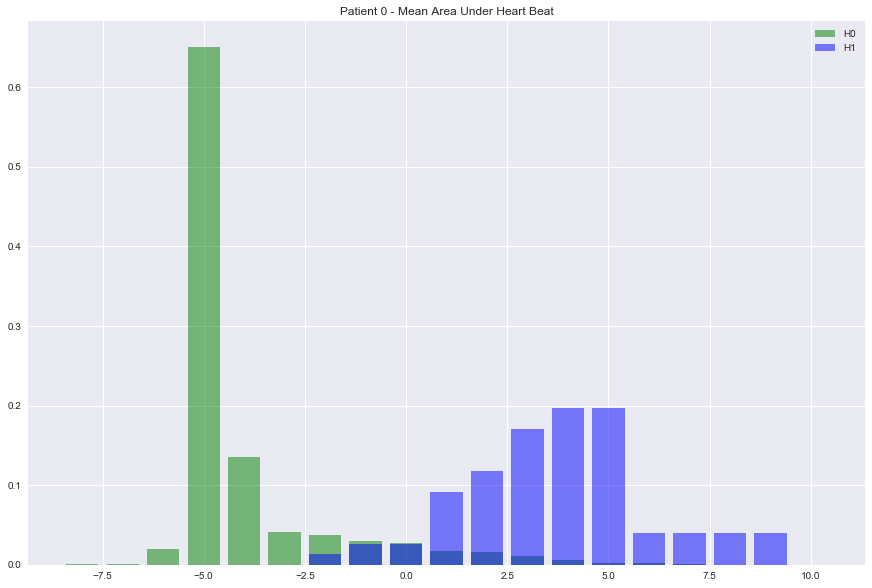

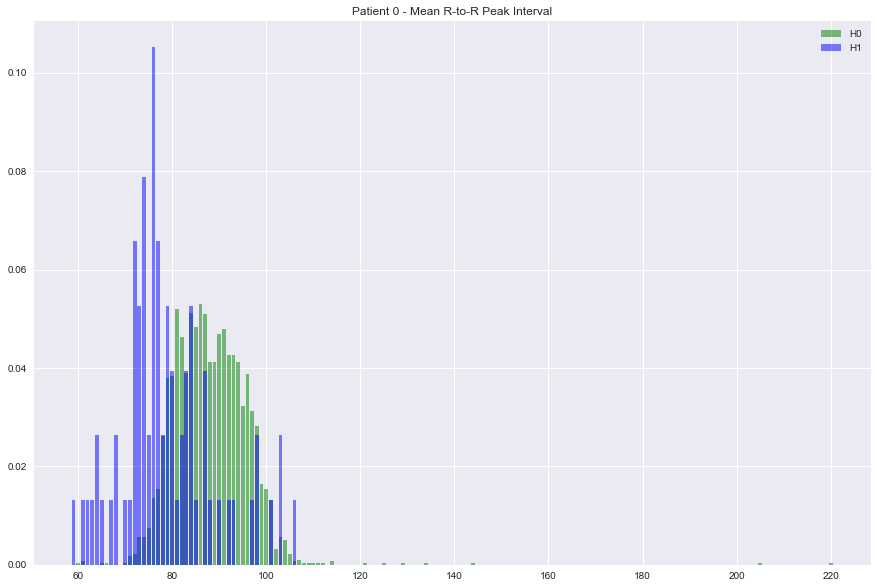

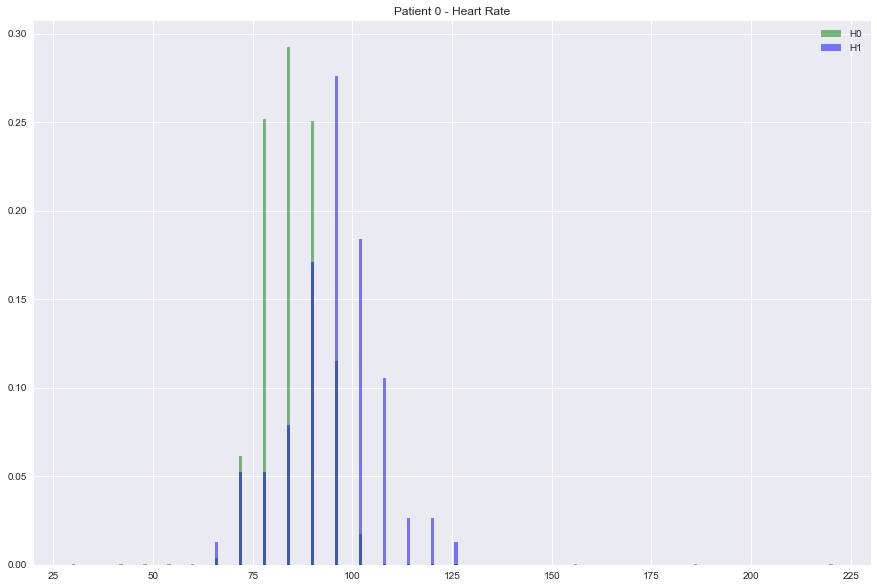

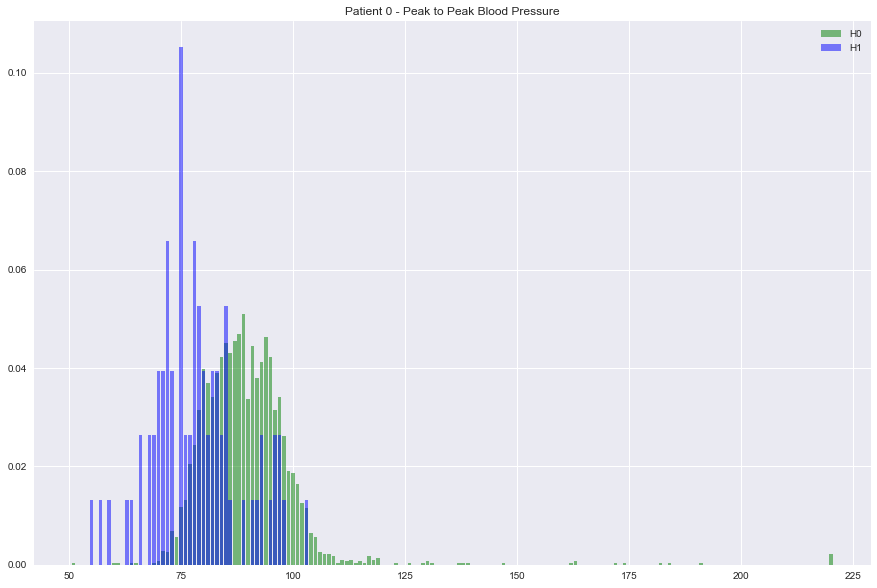

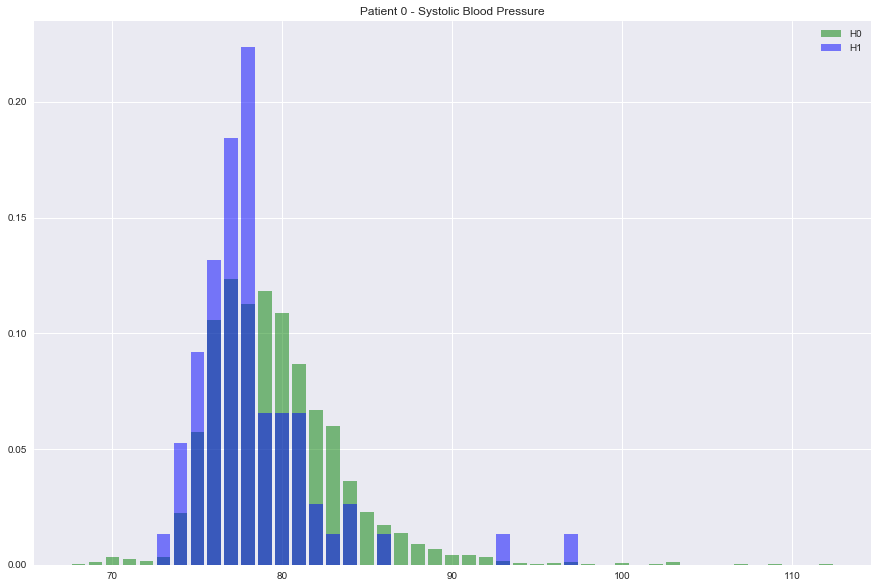

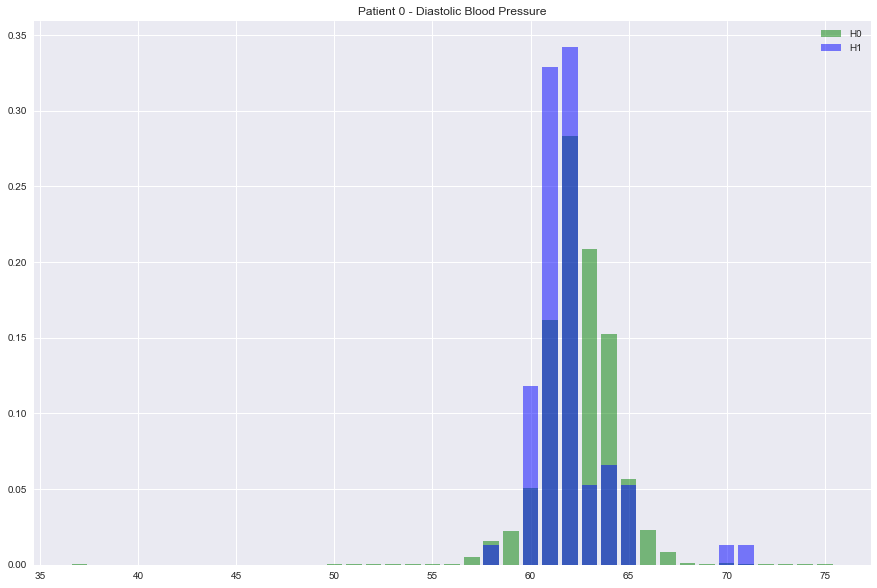

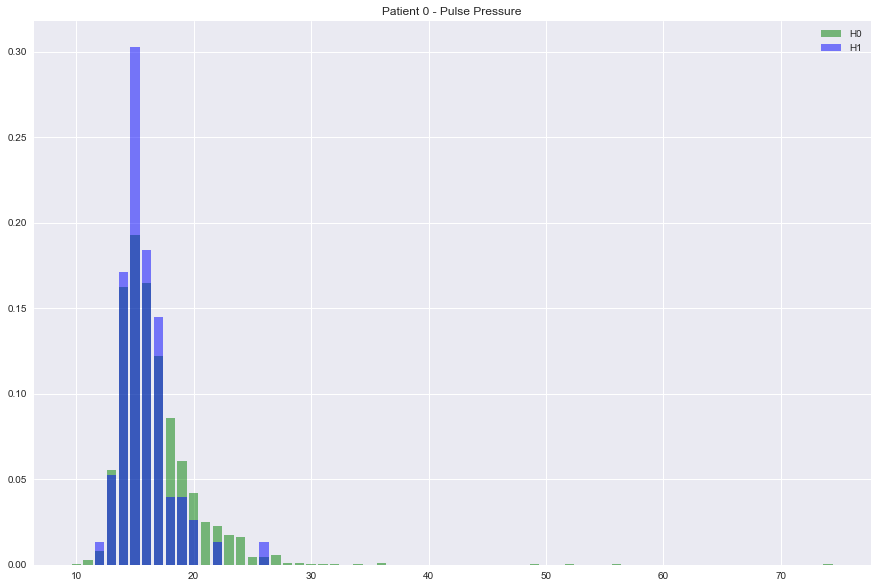

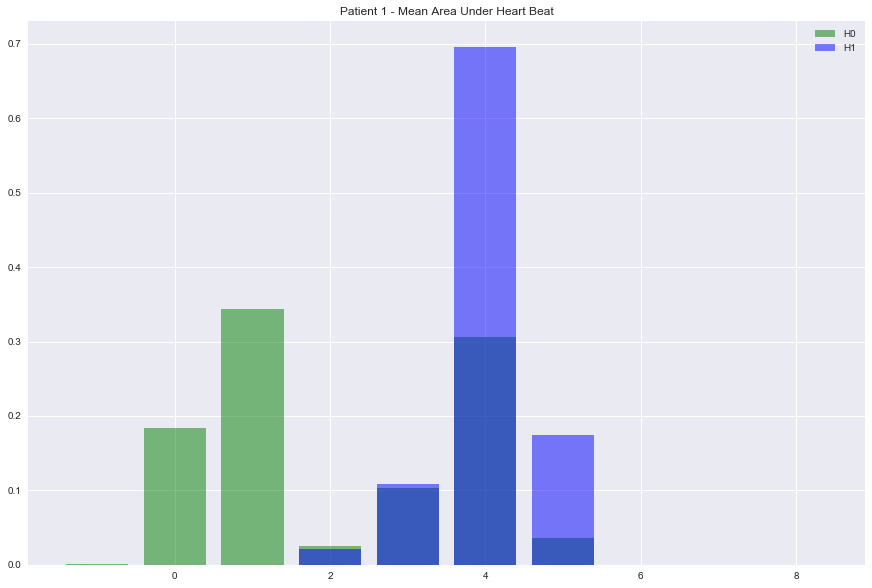

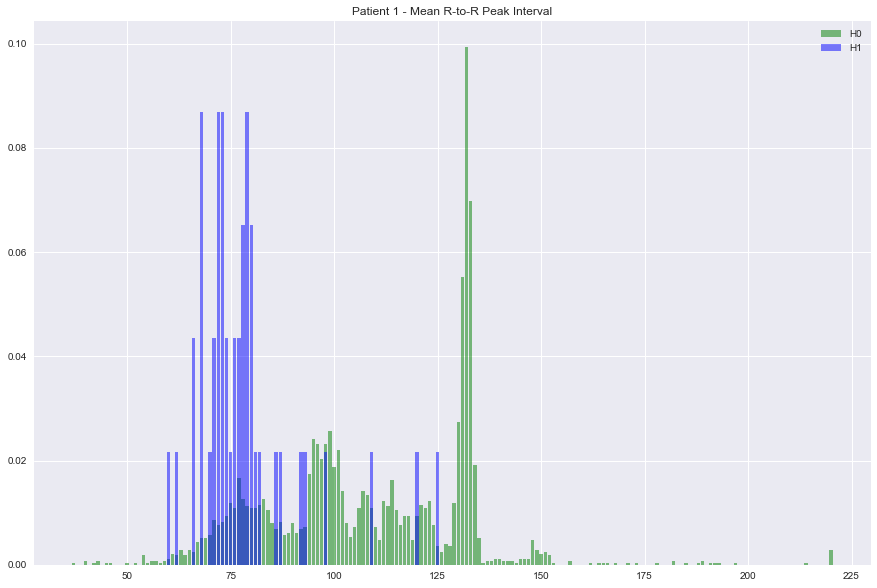

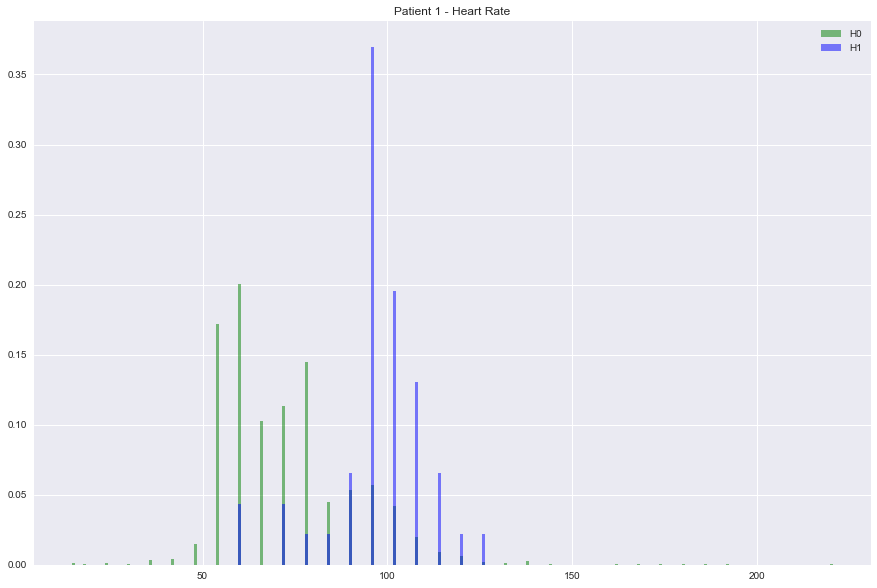

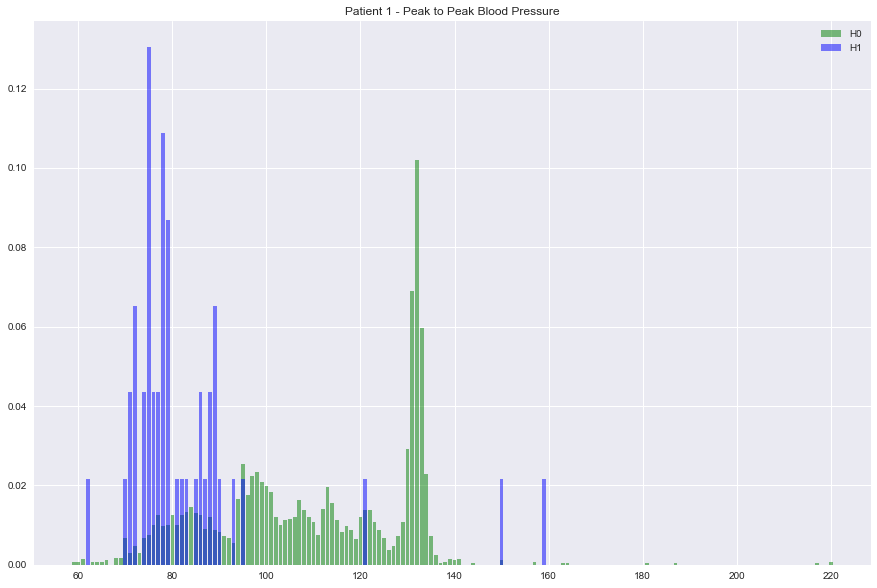

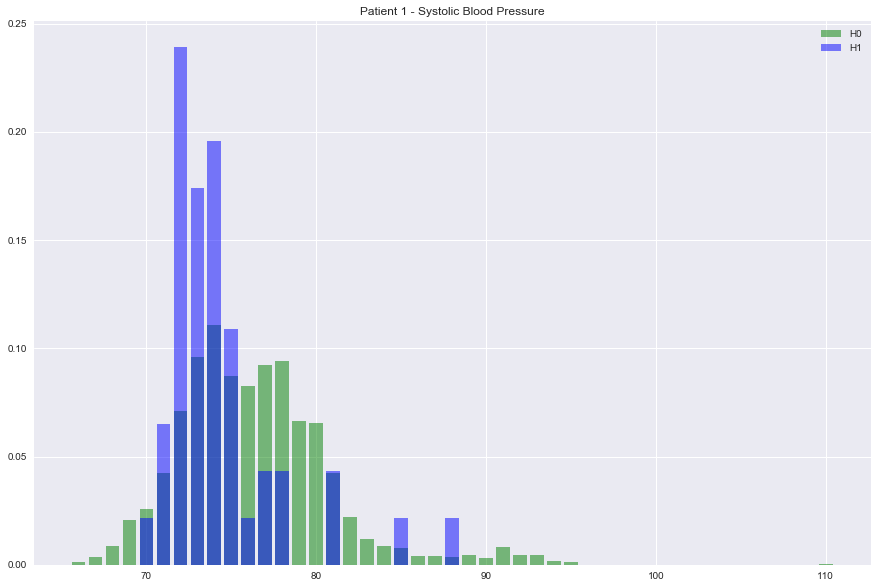

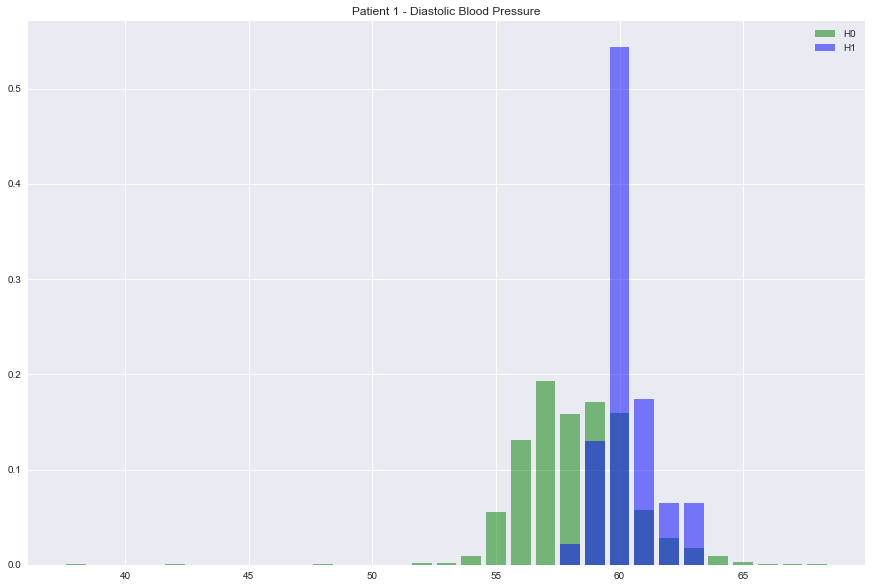

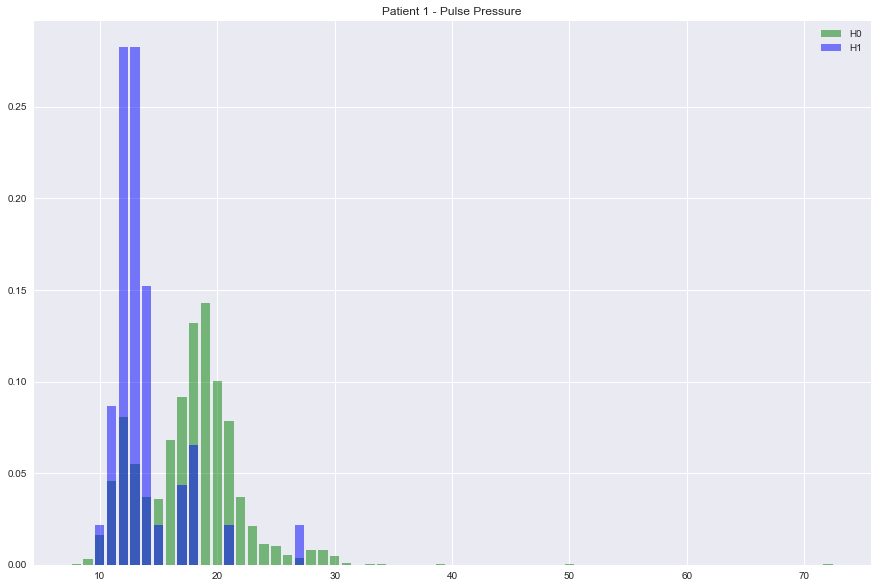

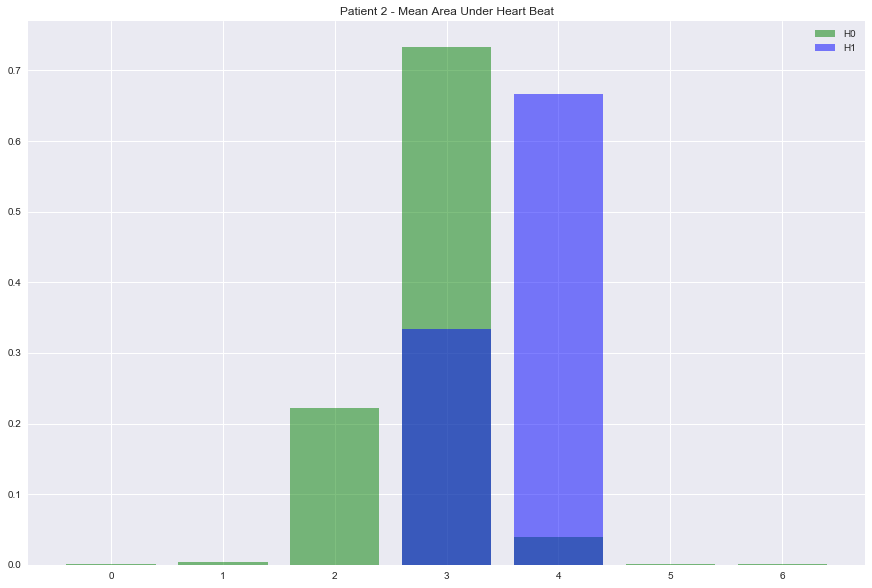

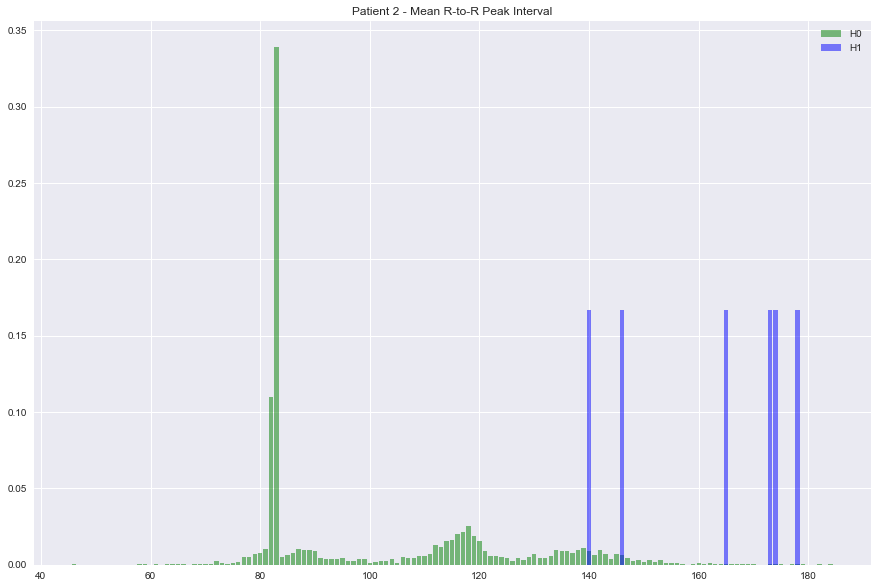

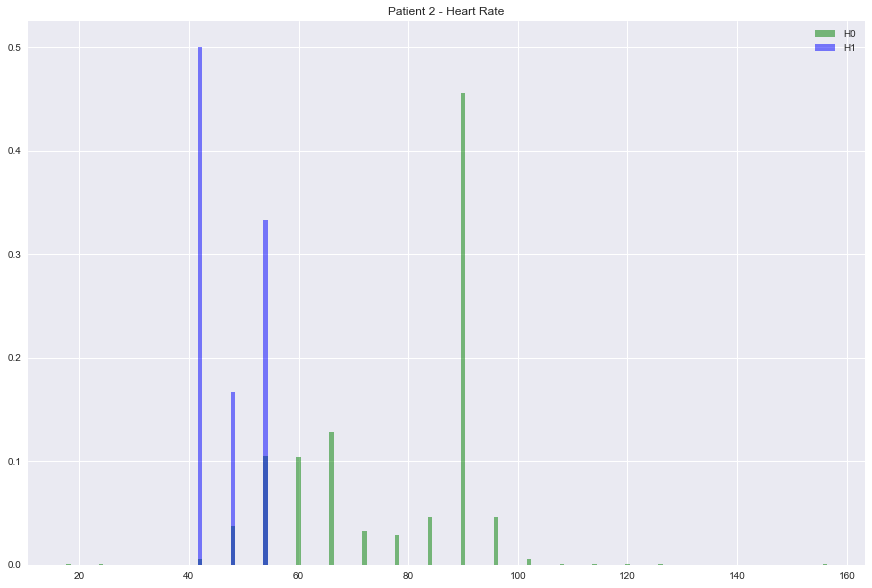

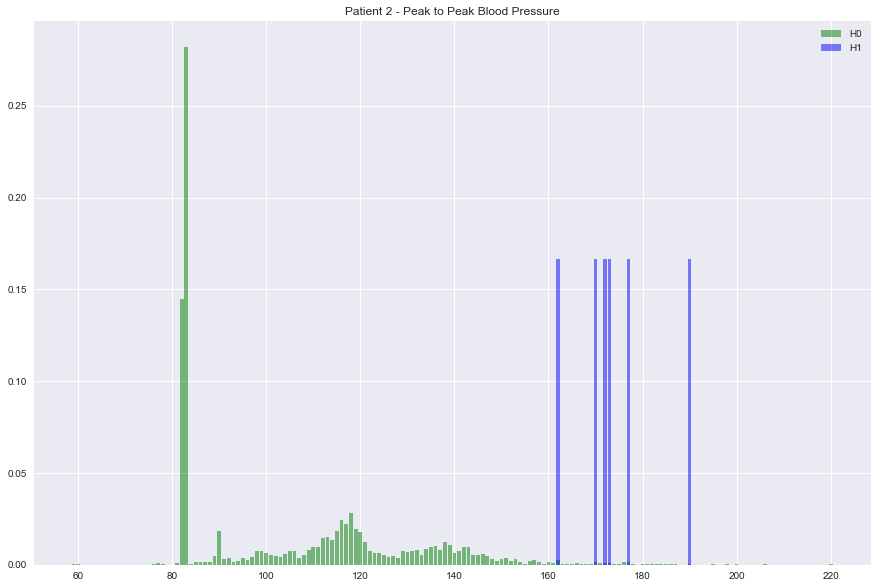

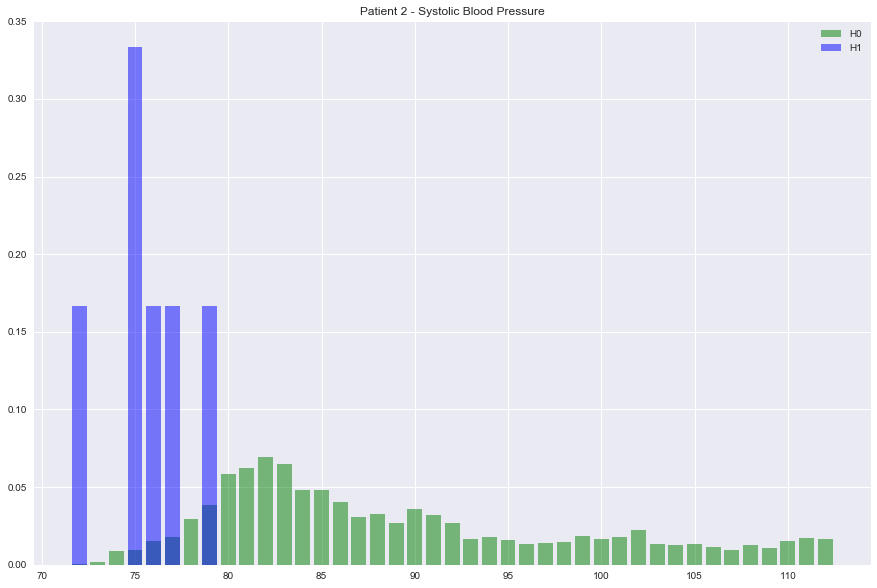

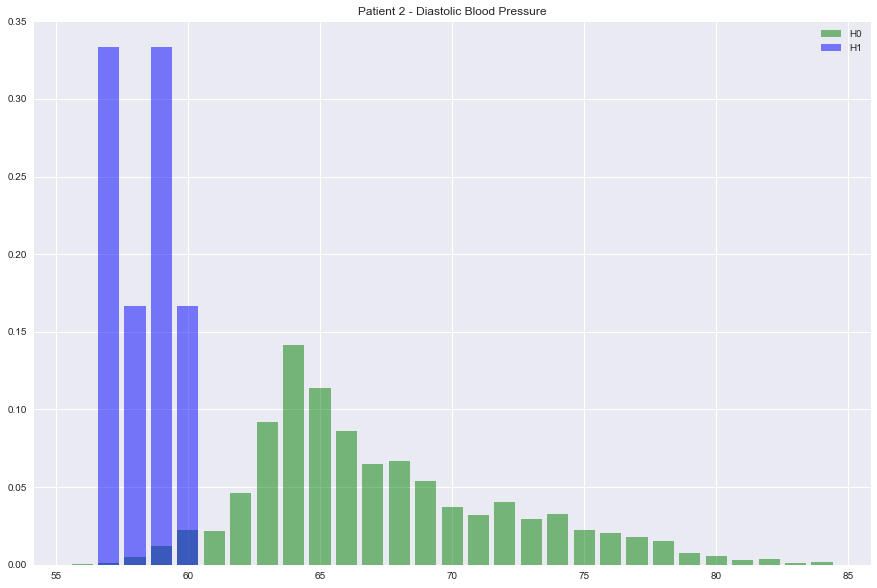

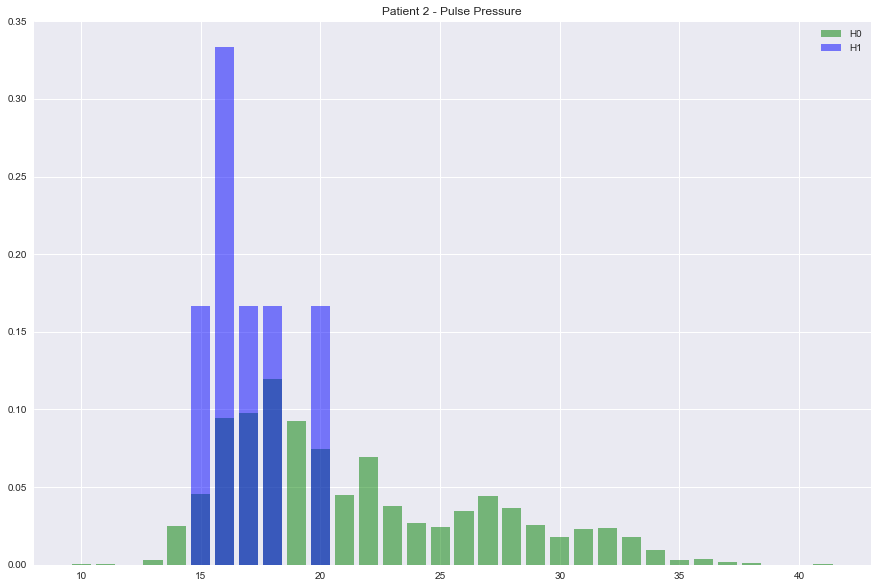

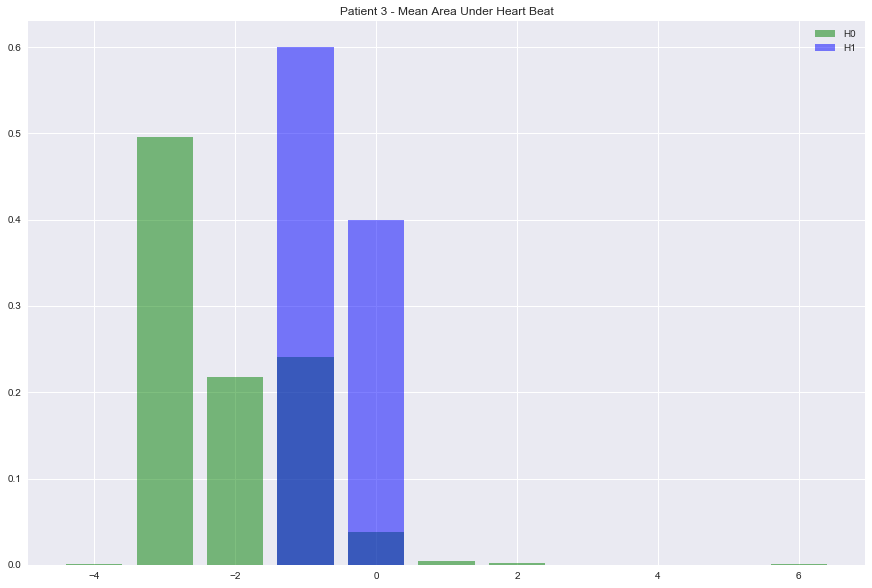

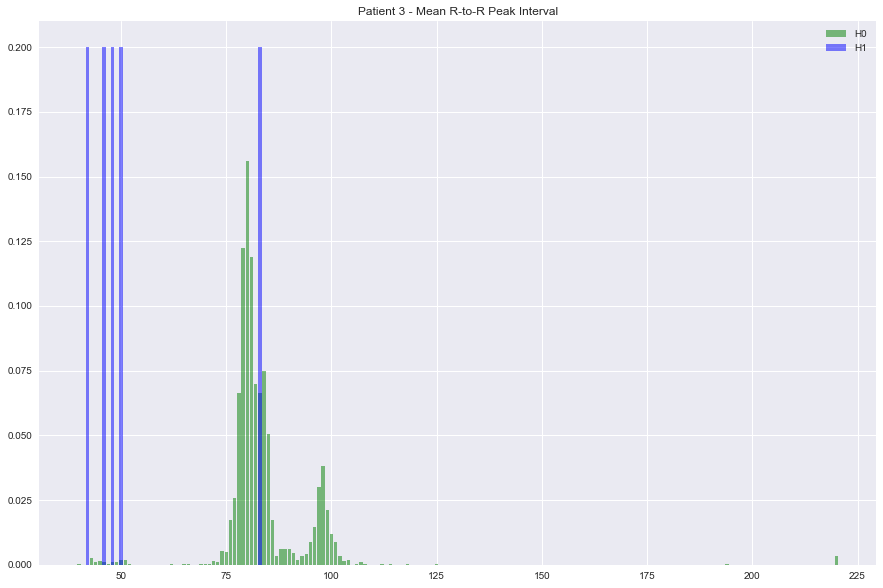

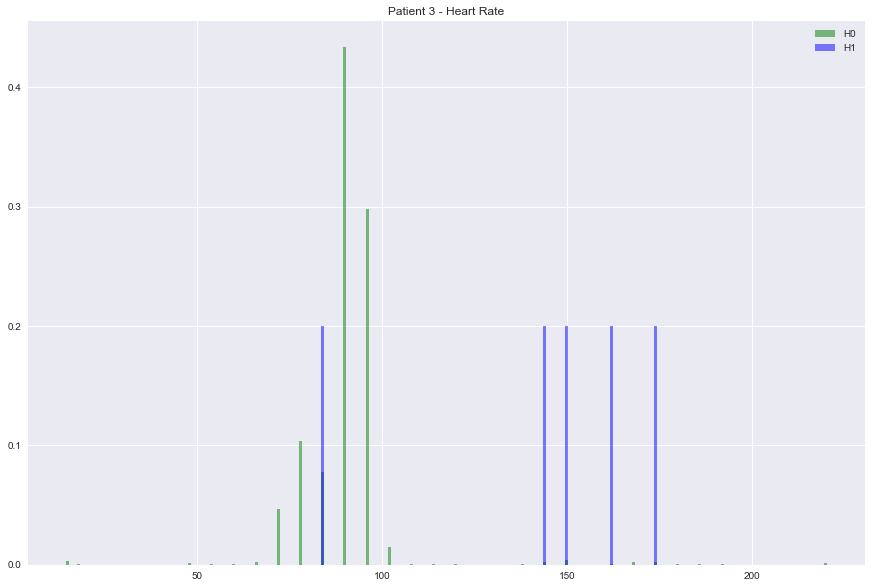

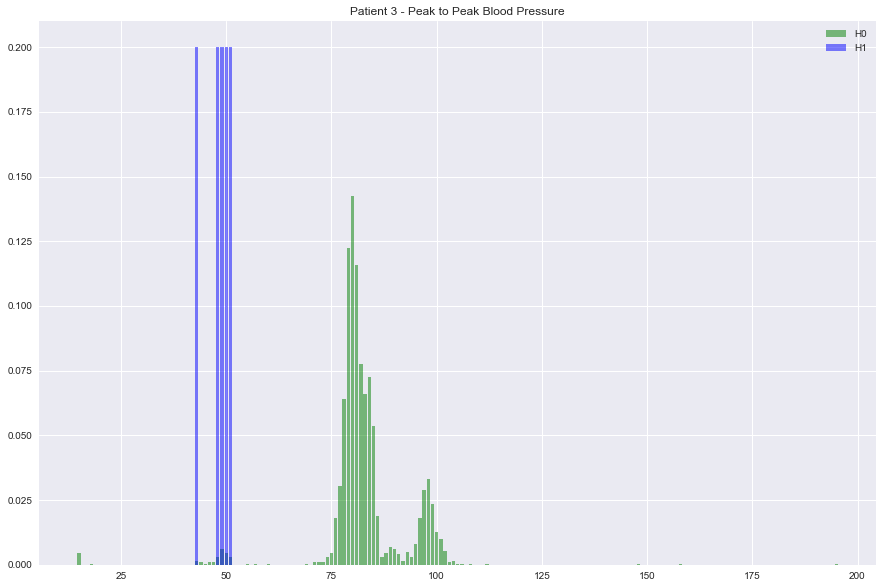

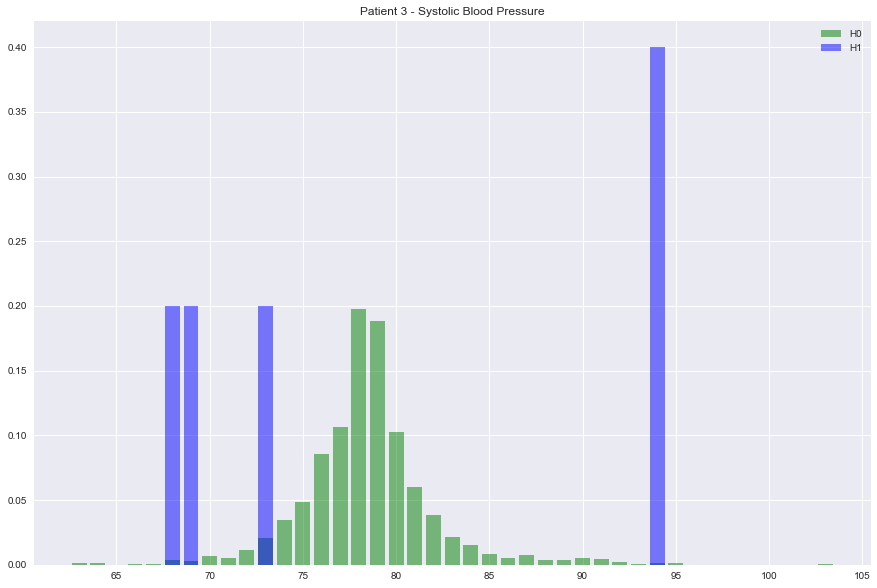

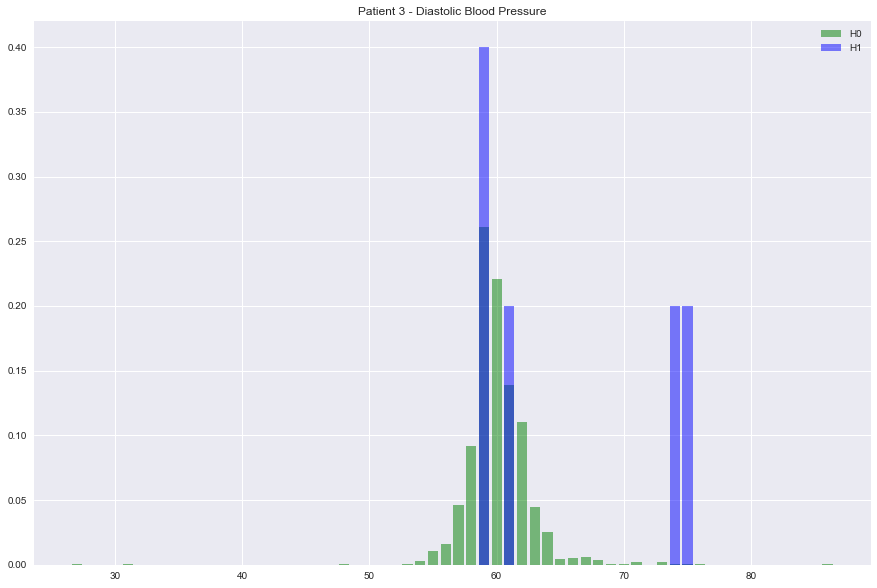

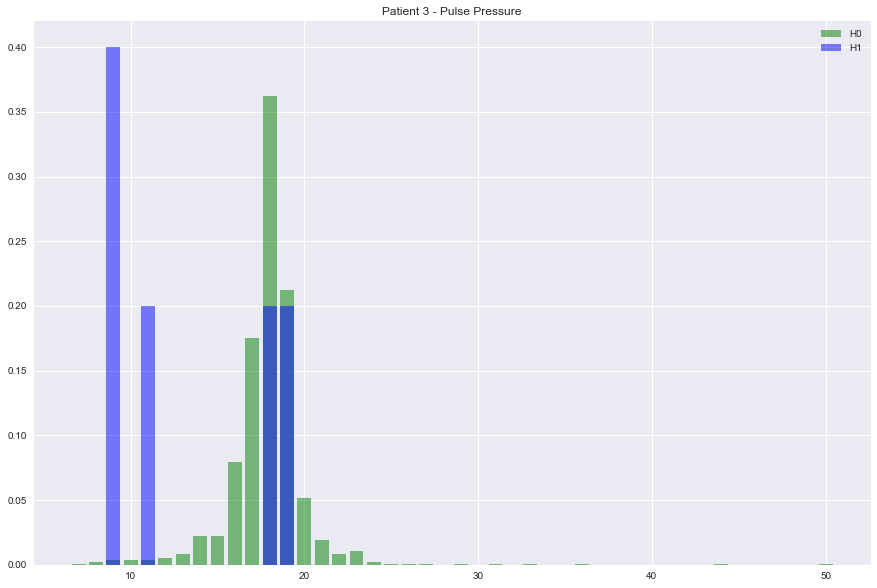

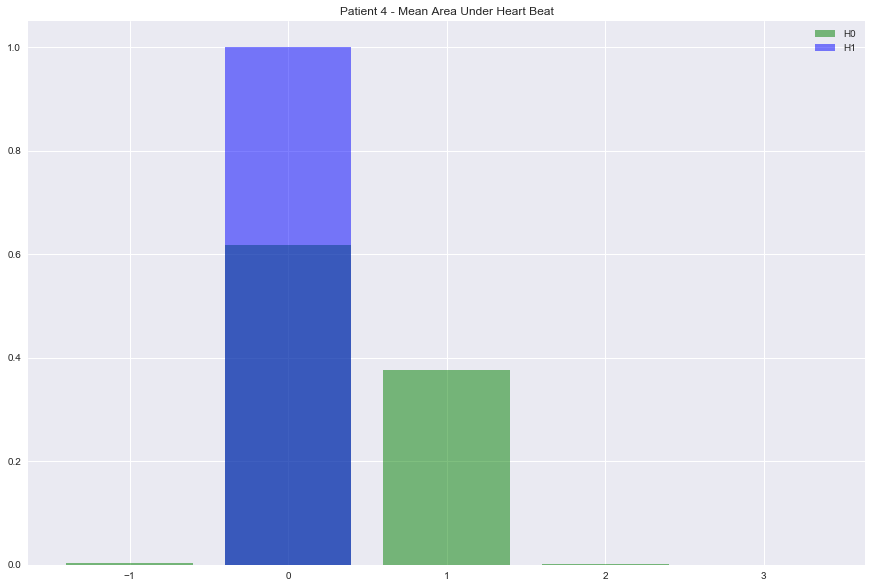

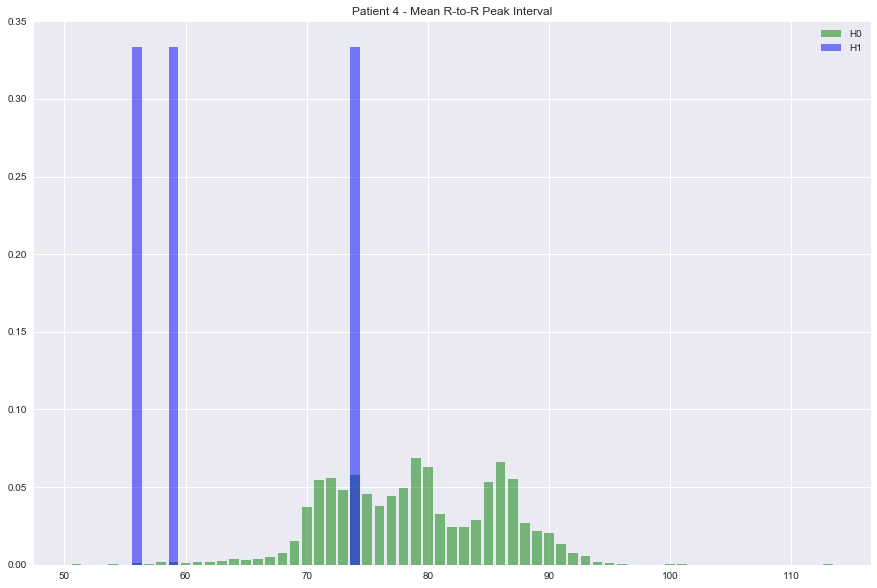

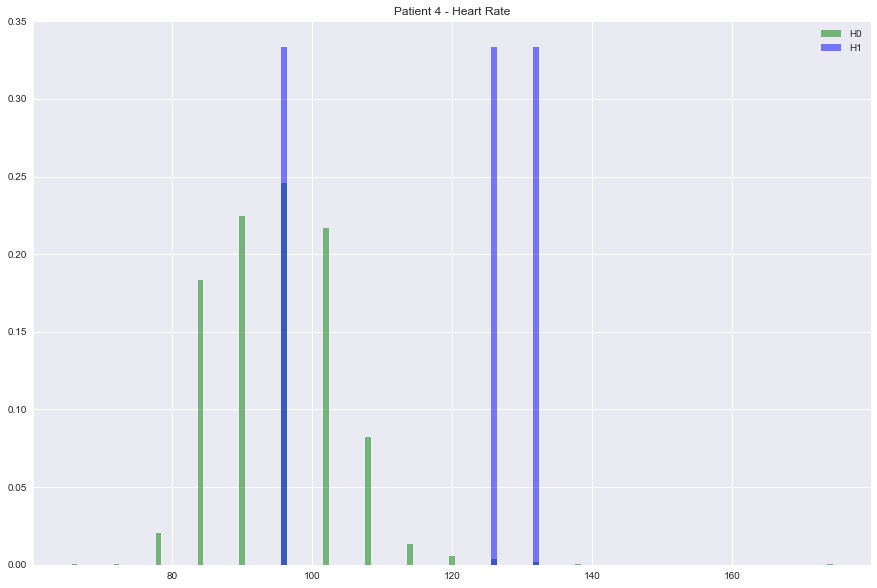

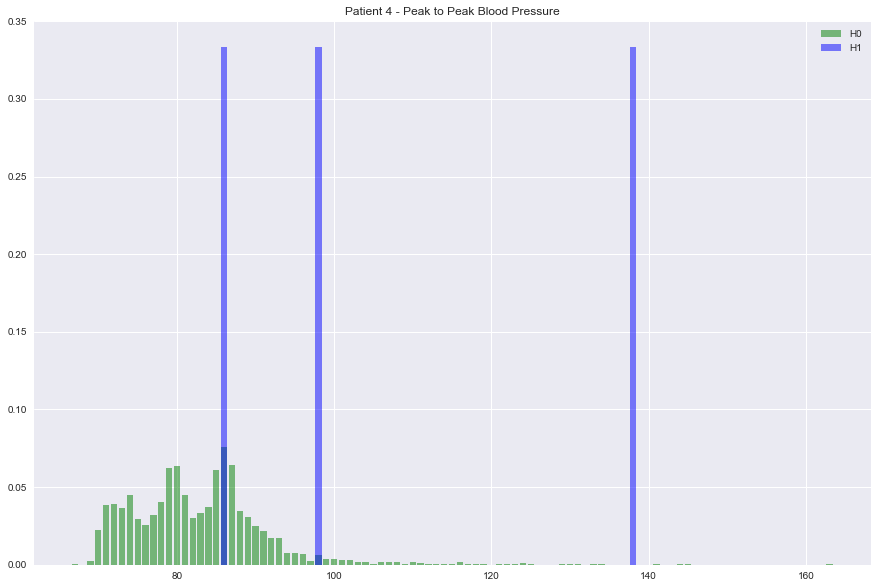

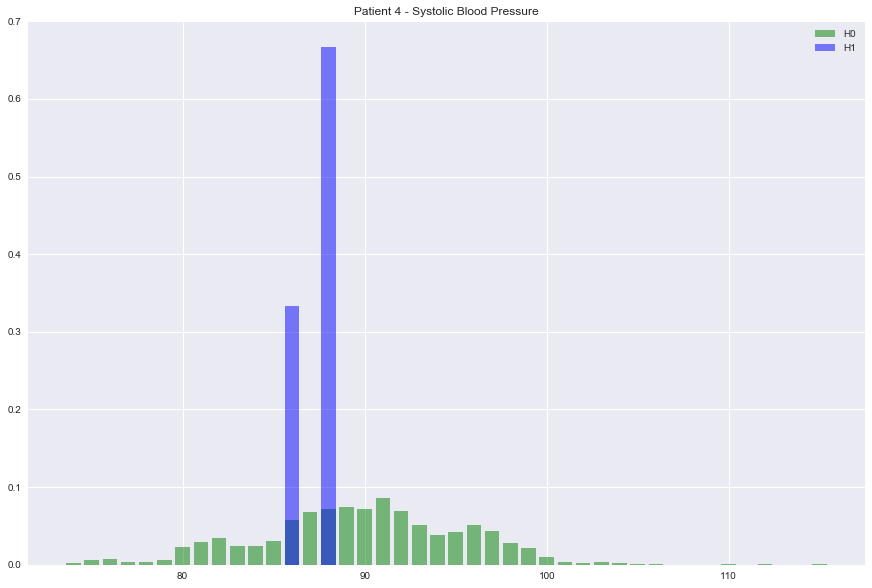

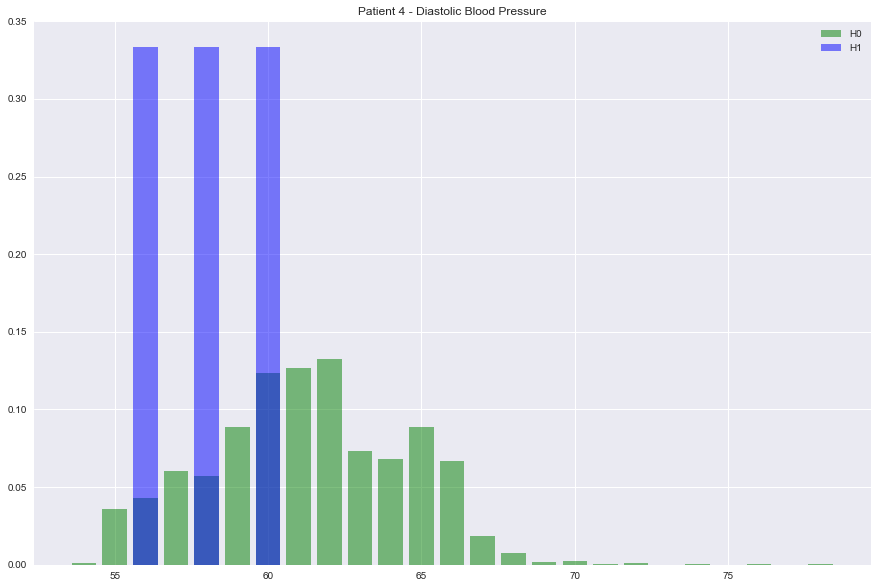

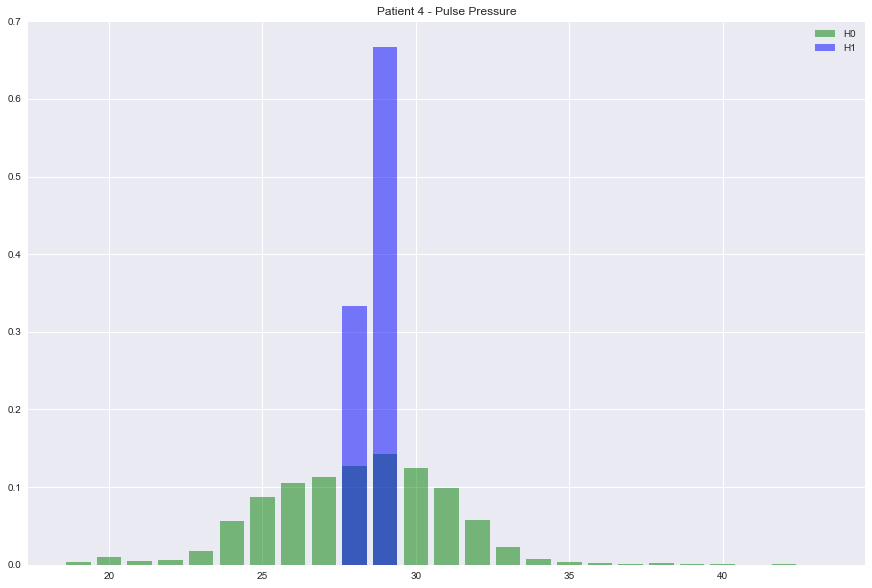

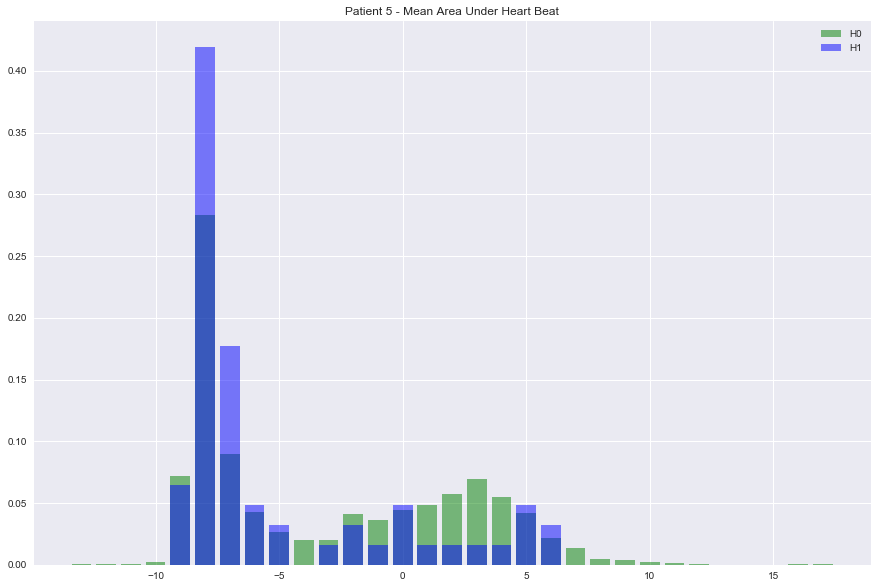

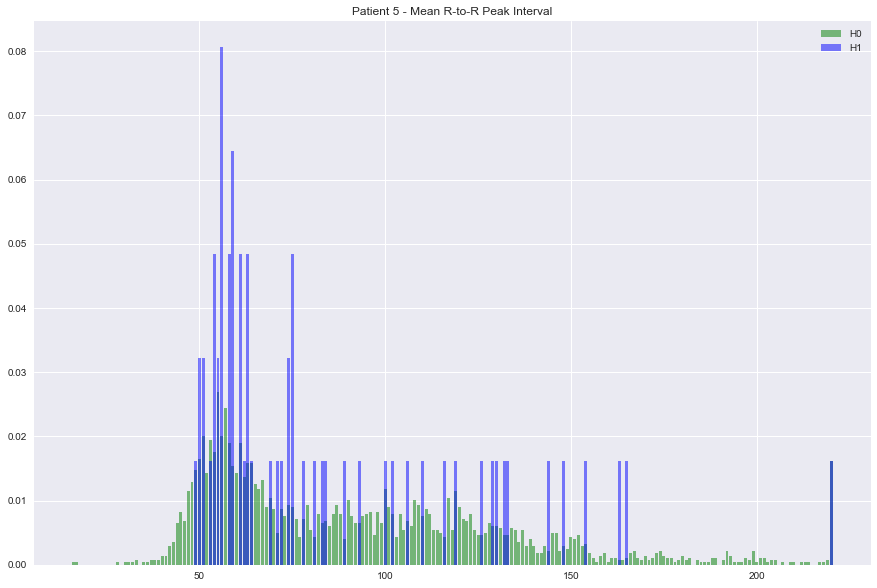

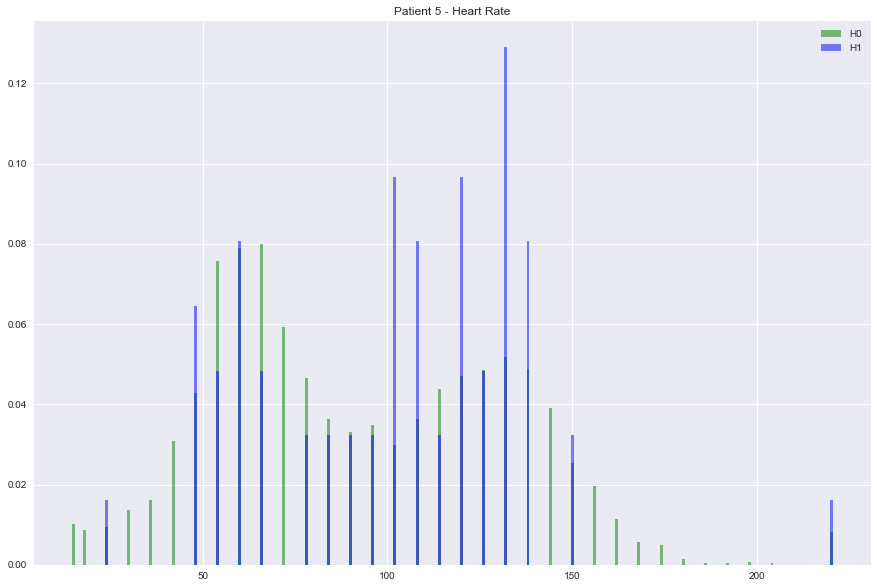

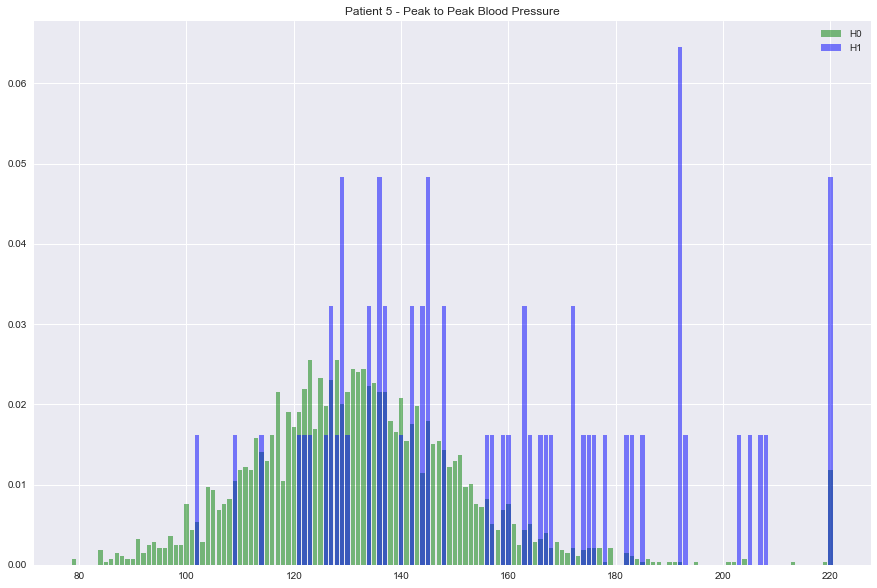

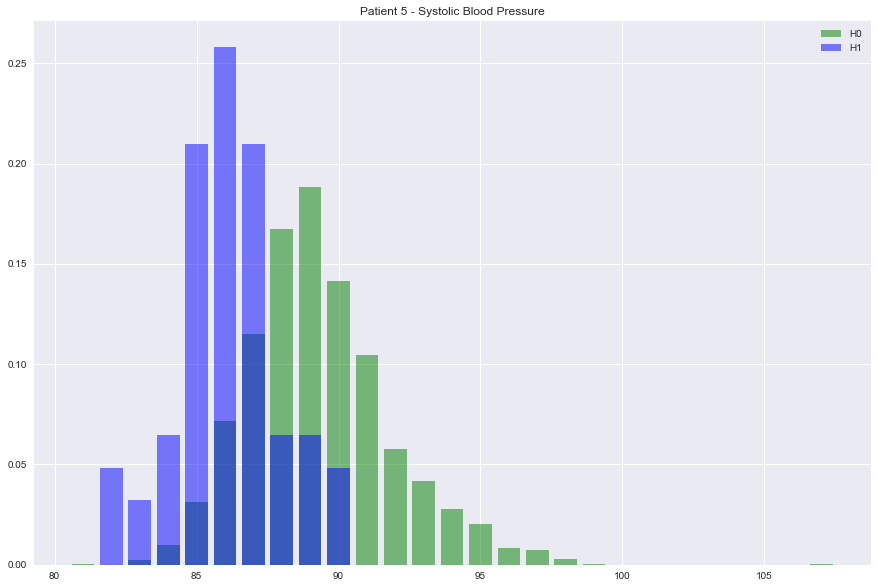

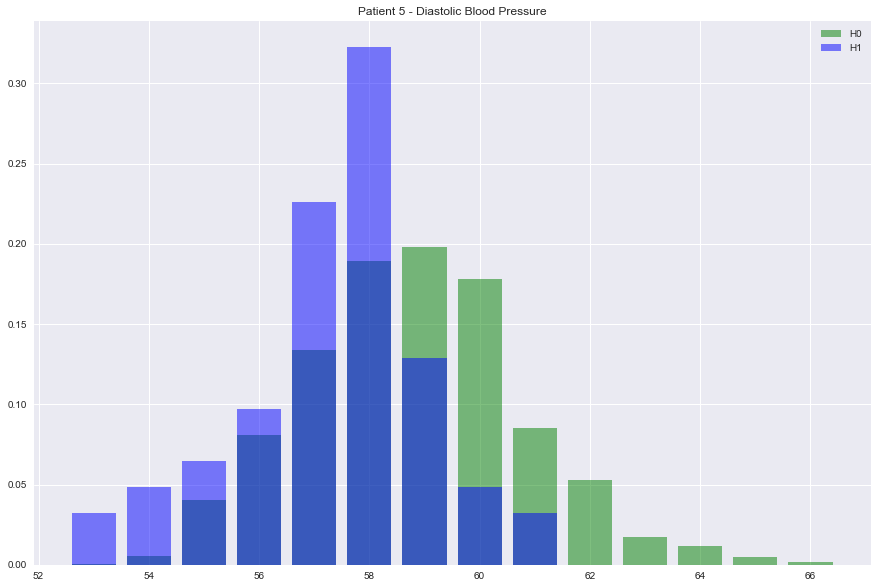

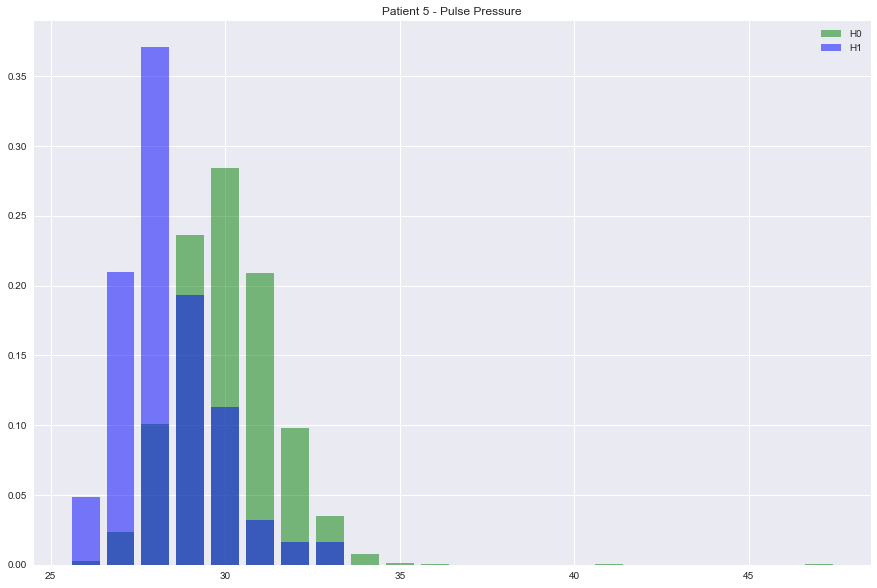

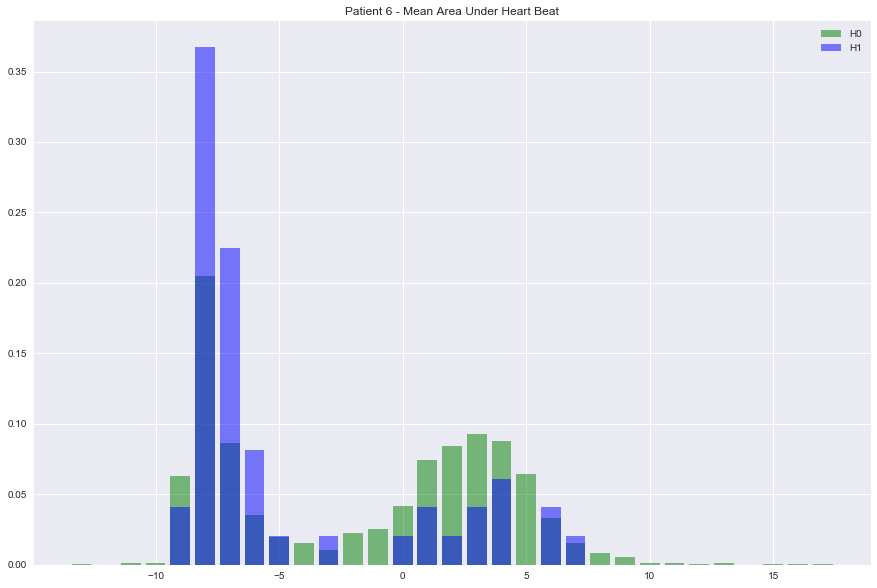

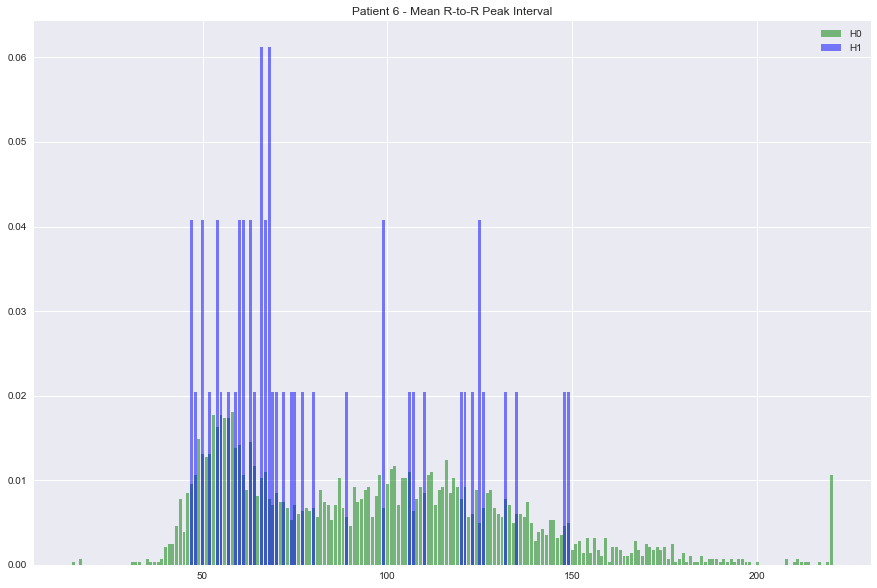

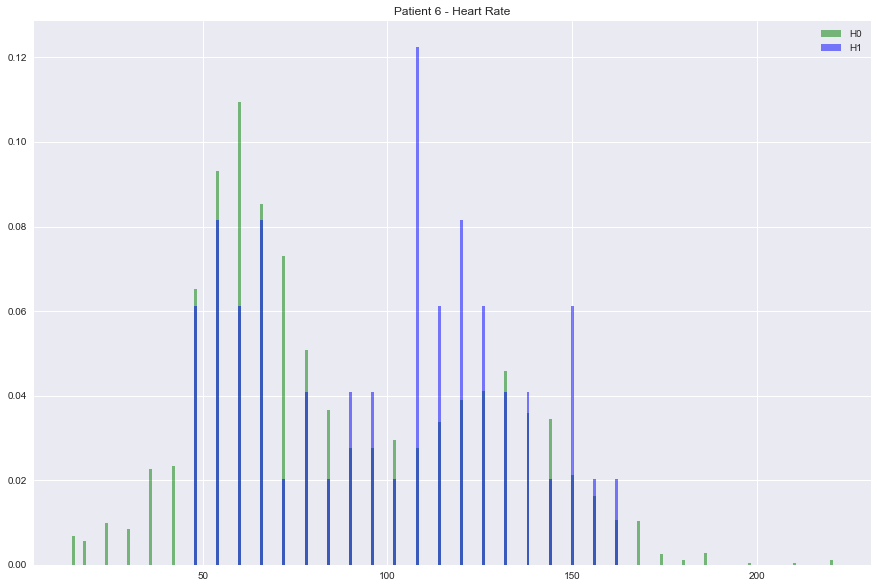

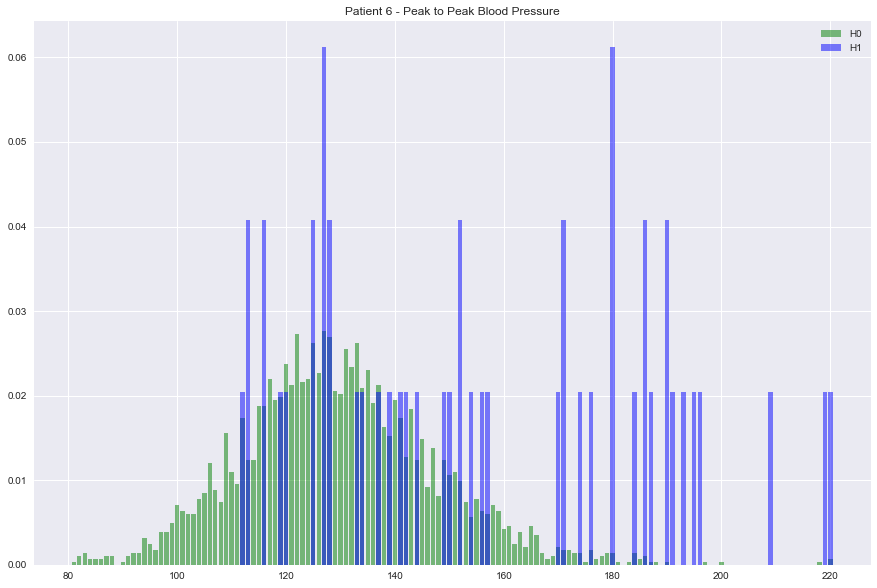

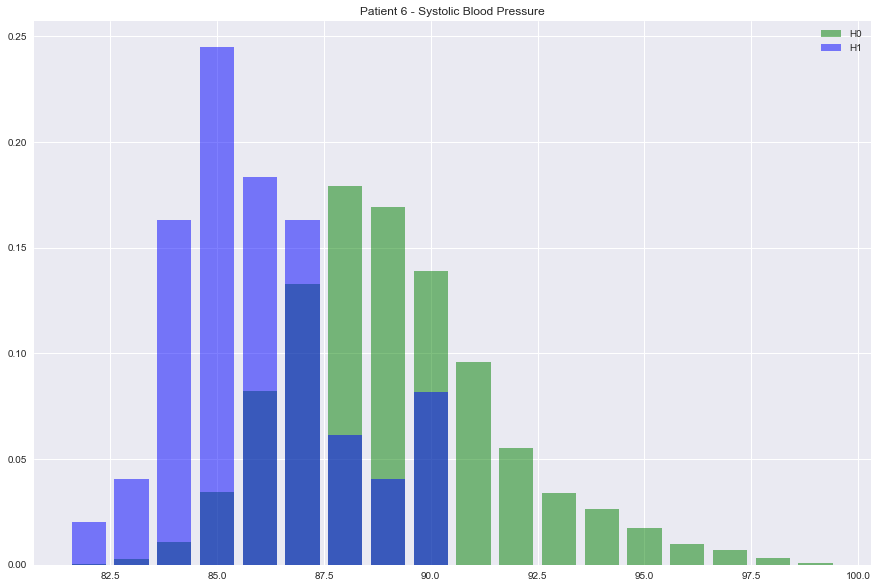

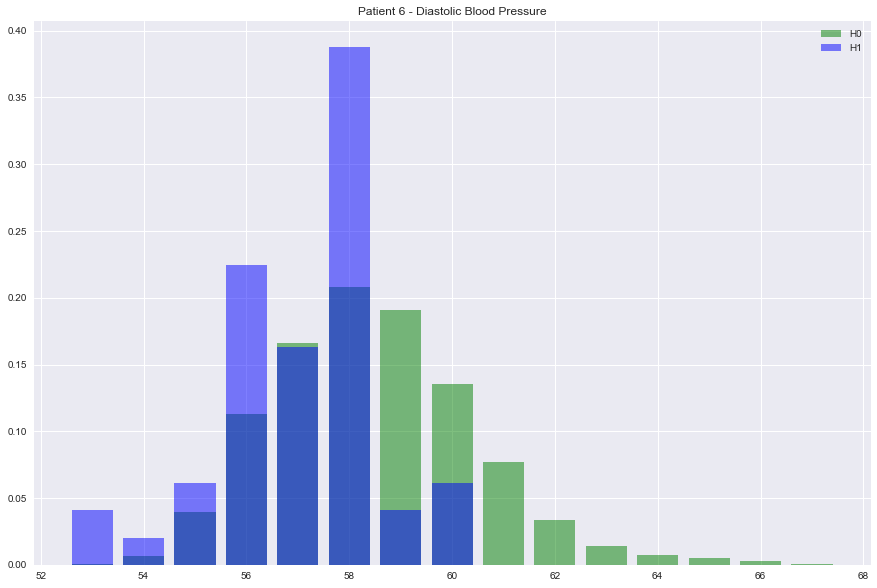

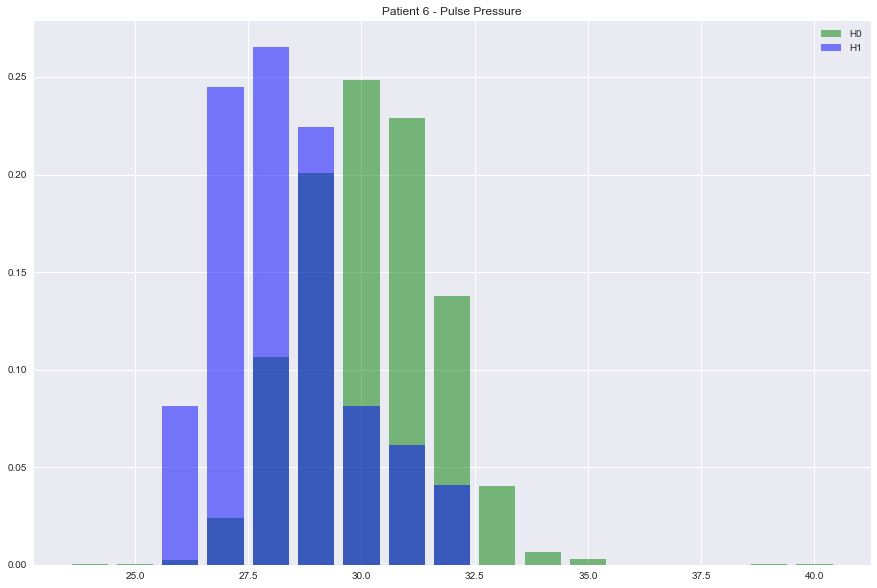

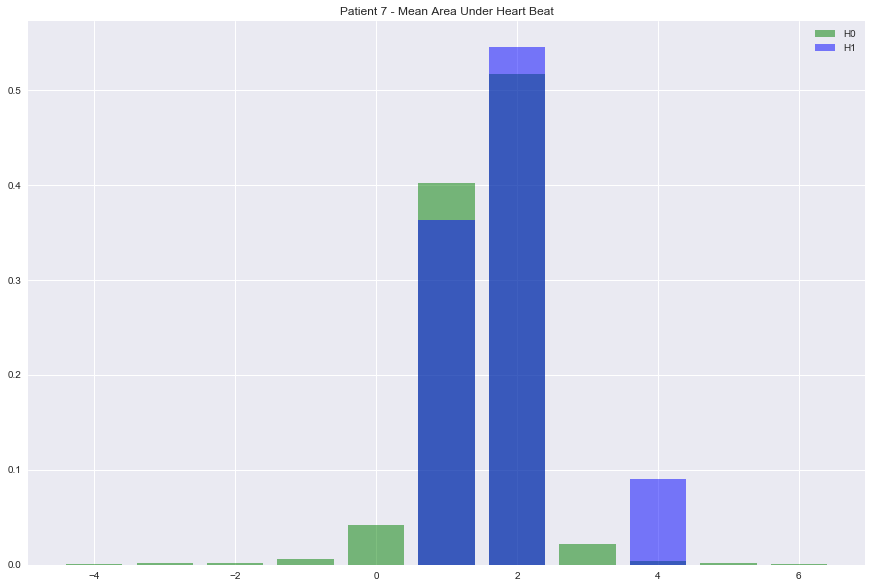

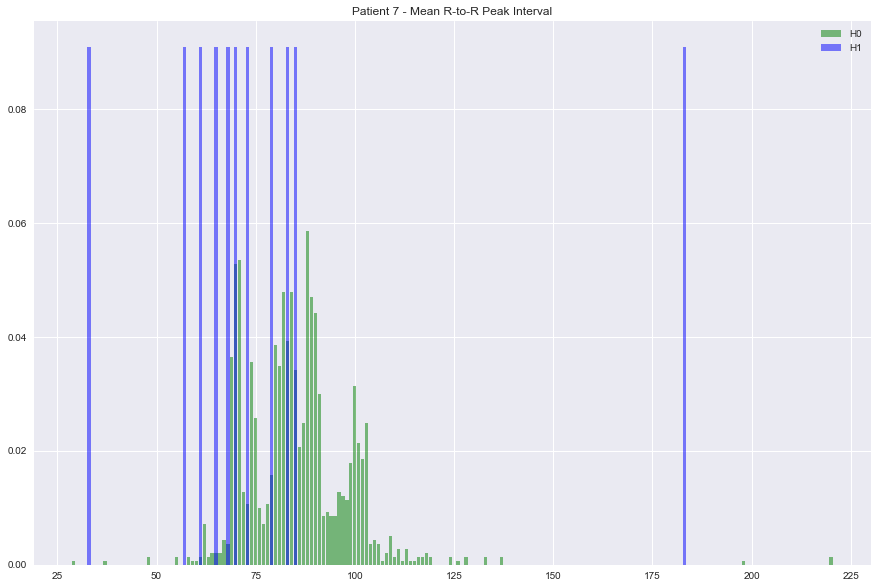

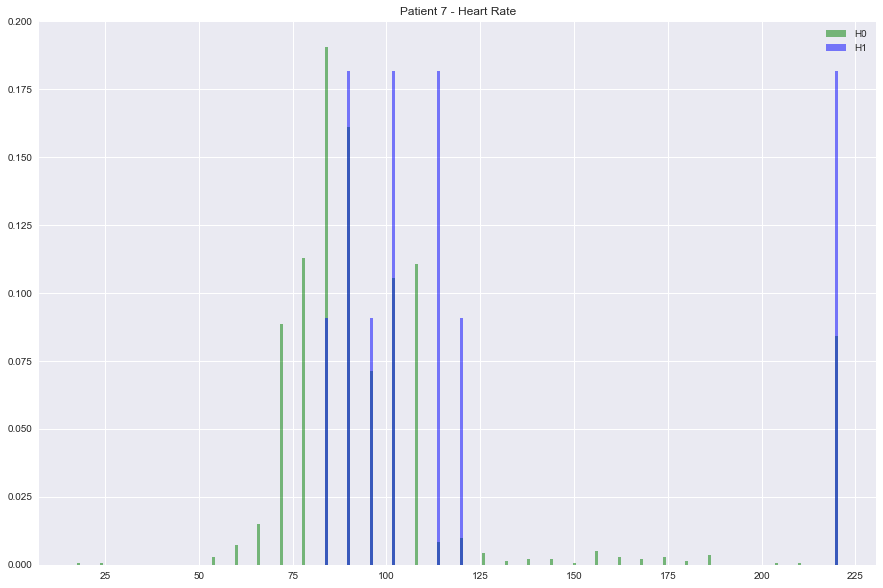

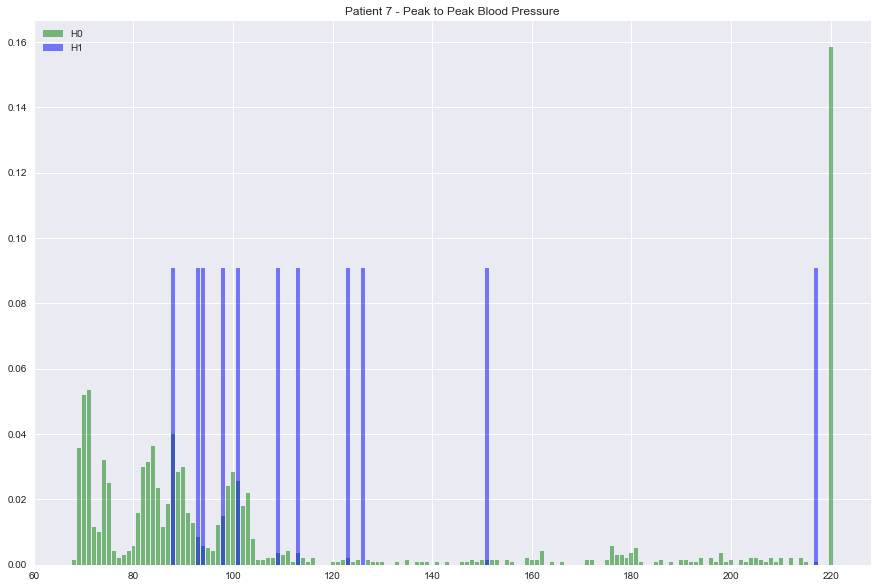

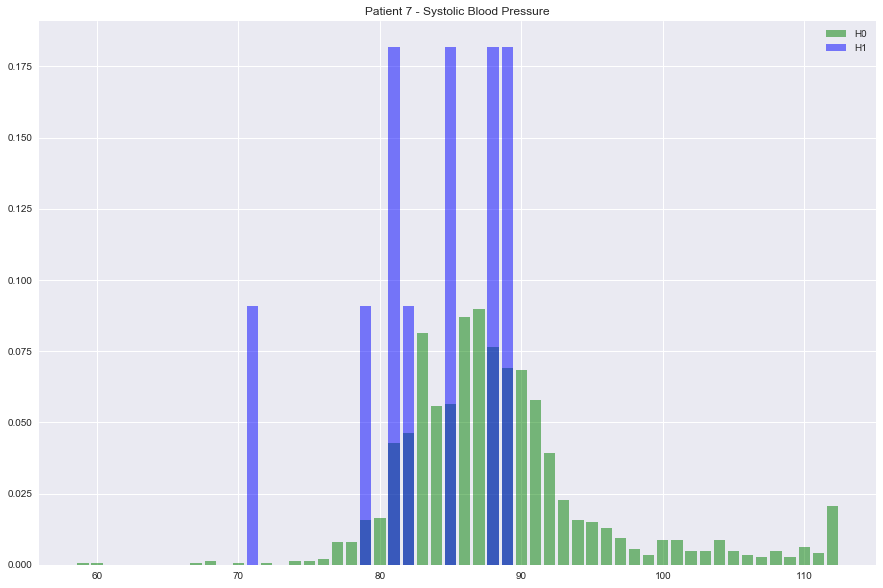

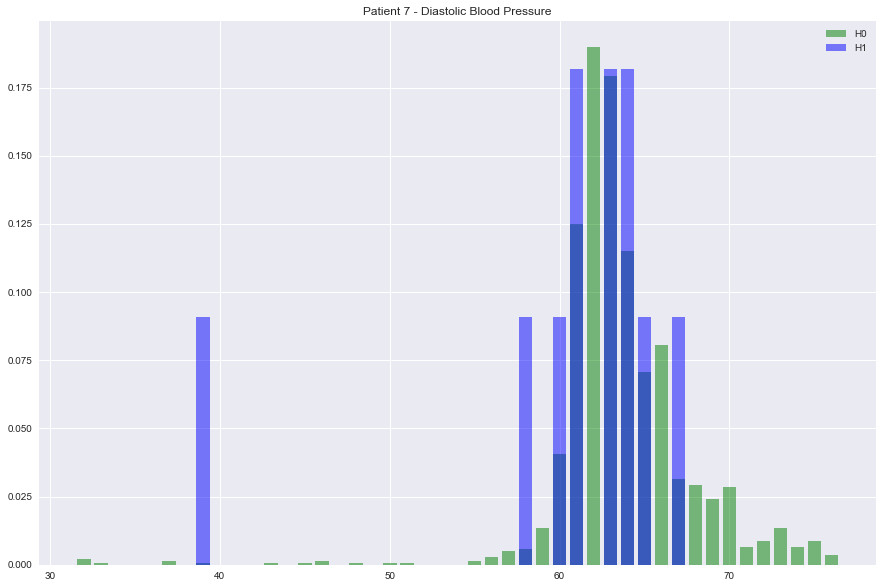

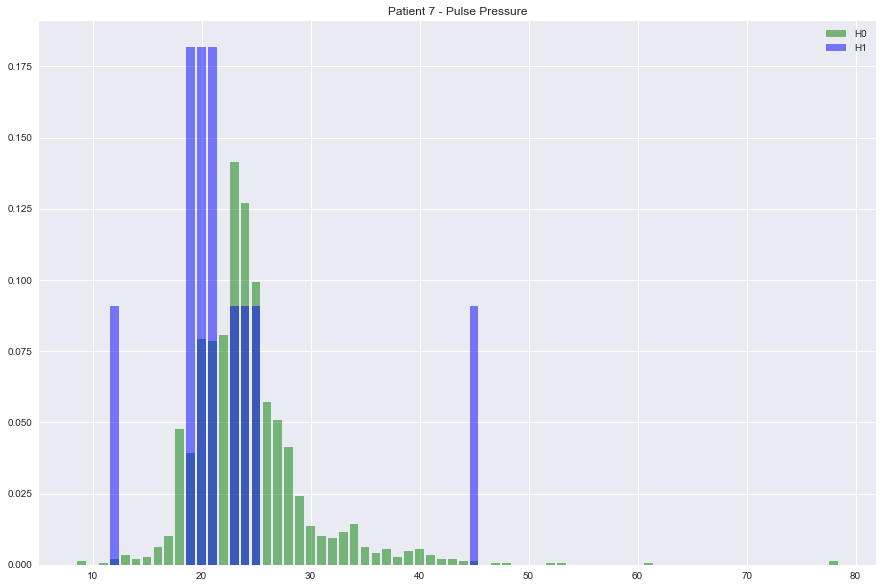

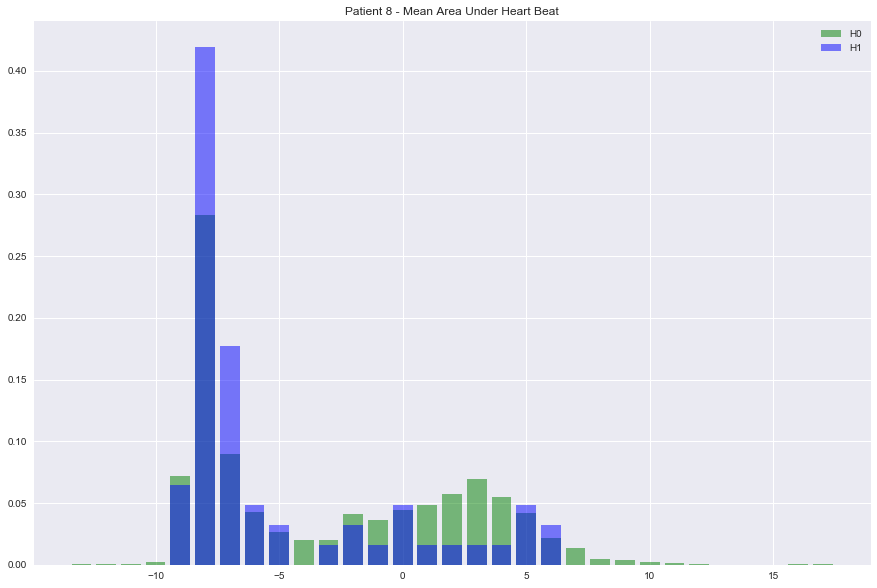

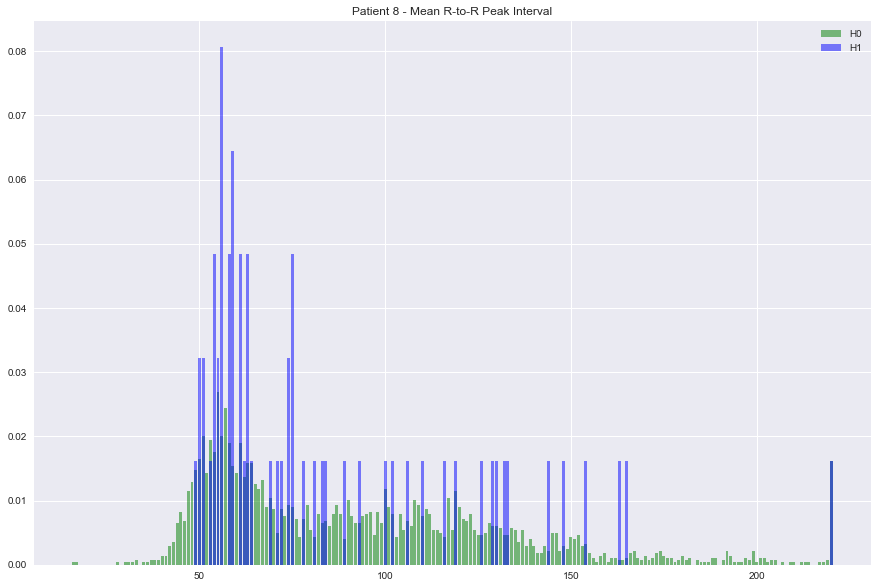

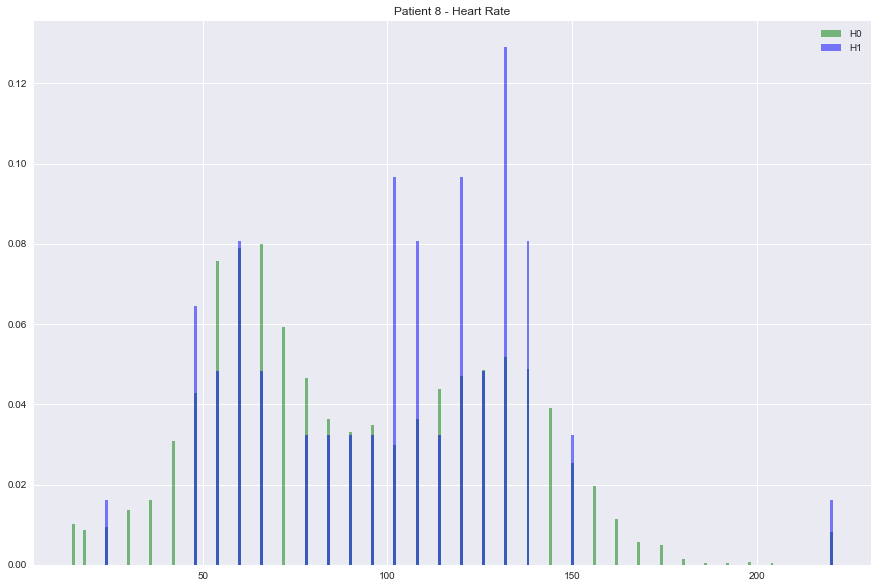

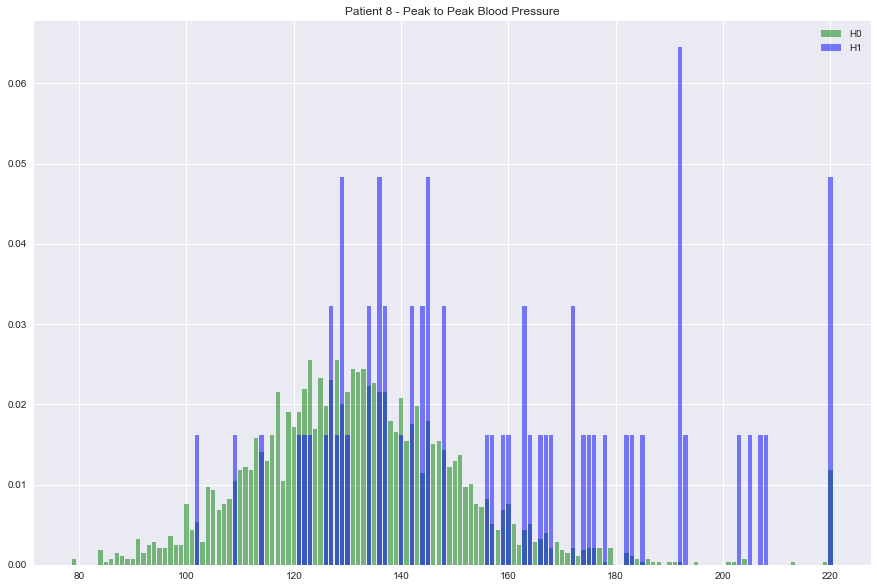

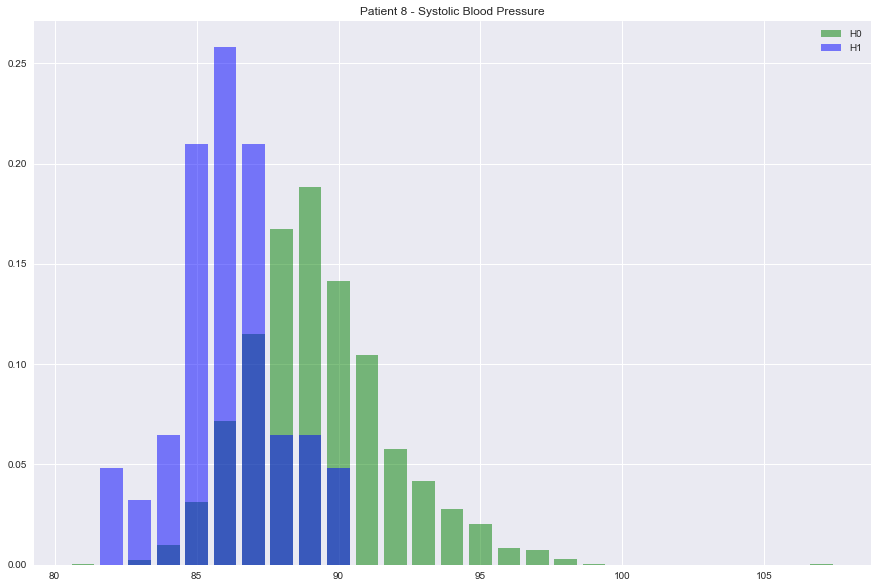

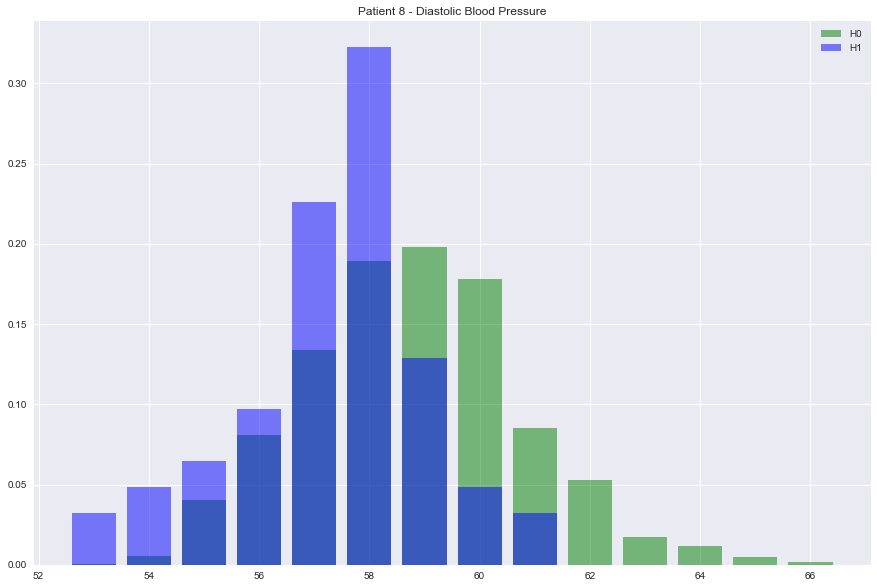

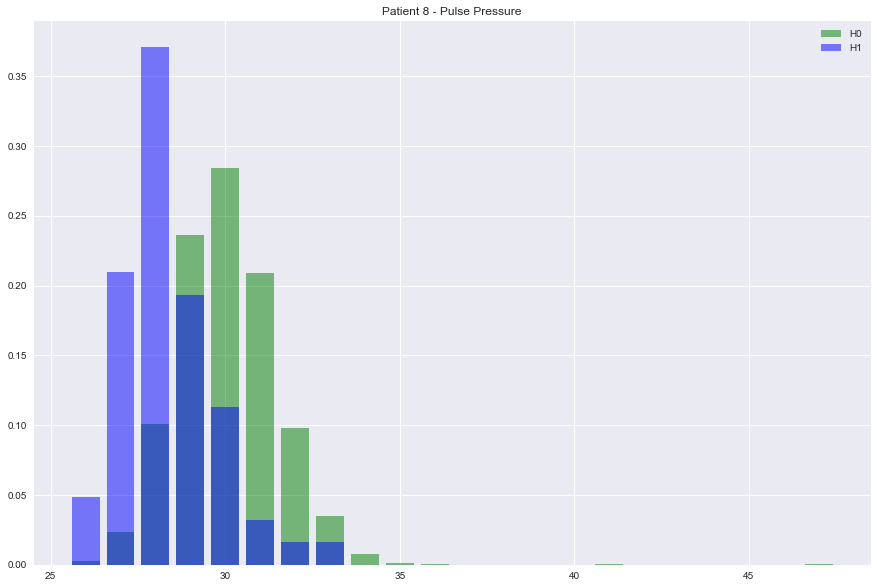

In [43]:
columns = [
    'Mean Area Under Heart Beat',
    'Mean R-to-R Peak Interval',
    'Heart Rate',
    'Peak to Peak Blood Pressure',
    'Systolic Blood Pressure',
    'Diastolic Blood Pressure',
    'Pulse Pressure'
]

bars = []
for patient_index, patient in enumerate(likelihood_matrix):
    for feature_index, feature in enumerate(patient):
        fig = plt.subplots(figsize=(15, 10))
        plt.bar(feature.index, feature[feature.columns[0]], width=0.8, alpha=0.5, color='green')
        plt.bar(feature.index, feature[feature.columns[1]], width=0.8, alpha=0.5, color='blue')
        plt.legend(['H0', 'H1'])
        plt.title('Patient %d - %s' % (patient_index, columns[feature_index]))
        bars.append(fig)

for bar in bars:
    plt.show()